<h1>Importando CSV</h1>
<p>Primeramente, são importados os arquivos CSV do conjunto de sequências de Teste</p>
<p>Então, é realizado o processo para a partir dos arquivos codingdata e encodeddata, gerar as tabelas com os atributos e os desfechos</p>
<p>É possível baixar os arquivos CSV <strong><a href="https://drive.google.com/drive/folders/1dFJJ9-agYP9NBp8OzrXSXdmfpoW_xq7P?usp=sharing">aqui</a></strong>. Observe que é necessário baixar o par <em>coding</em> e <em>encoded</em> data para o mesmo vídeo e QP.</p>

In [2]:
import pandas as pd
import numpy as np
import glob

training_set_videos = ["Tango2", "CatRobot", "BasketballDrive", "BQTerrace", "Johnny", "ArenaOfValor"]

# returns list of names of files that contain coding data of our training set
def get_training_test_codingdata_files():
      all_coding_data_files = glob.glob("/home/ruhan/Trabalho-ML/Outputs/codingdata_*.csv")
      training_set = []
      for file in all_coding_data_files:
            # Verificar se este é algum dos vídeos nomeados em training_set_videos:
            for training_set_video_name in training_set_videos:
                  if training_set_video_name in file:
                        training_set.append(file)

      return training_set

codingdata_files = get_training_test_codingdata_files()

print(f"Serão considerados os seguintes {len(codingdata_files)} CSVs:")
for i in codingdata_files:
      print(i)

processed_codingdata_dataframes = []

for codingdata_file in codingdata_files:

      print("Agora em: ", codingdata_file)

      df_codingdata = pd.read_csv(codingdata_file,sep="\t", names=["baseqp","cost","cunumberpel","currbtdepth","currdepth","currmtdepth","currqtdepth","currtrdepth","diagavg",
            "diagsad","diavar","diffminmax","distortion","fracbits","height","max","min","modetype","poc","qp",
            "pelavg","pelcornersavg","peldiffdiagonal","peldifffullcorneravg","squaredcu","videoresheight","videoreswidth",
            "treetype","width","x","y","prevpocheight","prevpocwidth","thisheightminusprevheight","thiswidthminusprevwidth",
            "thissizeminusprevsize"])

      df_codingdata = df_codingdata.query("cost > 0 and poc > 0 and width >= 32 and height >= 32 and width == height")
      #Considerar apenas Coding Units Quadradas (64 e 32), e que foram processadas pelo codificador.


      encodeddata_file = codingdata_file.replace("codingdata", "encodeddata")
      df_desfecho = pd.read_csv(encodeddata_file,sep="\t", index_col=0 ,names=["poc","depth","x","y","w","h"])

      pocs = np.unique(df_desfecho['poc']) #Gera uma lista de POCs (indice do frame no video)

      df_desfecho_collection = {}

      for ppoc in pocs:
            df_desfecho_collection[ppoc] = df_desfecho.query("@ppoc == poc")


      def setTarget(line) :
      
            xI = line['x']   
            yI = line['y']
            h = line['height']
            w = line['width']
            poc = line['poc']
            
            xF = xI+w-1
            yF = yI+h-1

            filtered_target = df_desfecho_collection[poc].query('x < @xF and y < @yF and x >= @xI and y >= @yI')

            if(len(filtered_target) <= 1):
                  return 0 #Dont split
            else :
                  return 1 #Split
      
      targets = df_codingdata.apply(setTarget , axis=1)

      df_codingdata['target'] = targets

      processed_codingdata_dataframes.append(df_codingdata)

# Create a combined dataframe wilh all the coding data of all video sequences.
df_codingdata = pd.concat(processed_codingdata_dataframes)

Serão considerados os seguintes 24 CSVs:
/home/ruhan/Trabalho-ML/Outputs/codingdata_Tango2_3840x2160_60fps_10bit_420_22.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_BQTerrace_1920x1080_60_27.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_Tango2_3840x2160_60fps_10bit_420_37.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_Johnny_1280x720_60_22.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_CatRobot_3840x2160_60fps_10bit_420_22.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_CatRobot_3840x2160_60fps_10bit_420_27.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_CatRobot_3840x2160_60fps_10bit_420_32.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_BasketballDrive_1920x1080_50_22.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_BasketballDrive_1920x1080_50_27.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_BQTerrace_1920x1080_60_32.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_ArenaOfValor_1920x1080_60_8bit_420_27.csv
/home/ruhan/Trabalho-ML/Outputs/codingdata_Johnny_1280x720_60_37.csv
/home/ruhan

In [11]:
print(len(df_codingdata[df_codingdata['target']==0]))
print(len(df_codingdata[df_codingdata['target']==1]))

594481
2153621


In [12]:
dados = df_codingdata.query('poc > 0 and cost > 0').filter(['cost',"cunumberpel","currbtdepth","currdepth","currmtdepth","currqtdepth","currtrdepth","diagavg",
      "diagsad","diavar","diffminmax","distortion","fracbits","height","max","min","modetype","qp",
      "pelavg","pelcornersavg","peldiffdiagonal","peldifffullcorneravg","squaredcu","videoresheight","videoreswidth",
      "treetype","width","prevpocheight","prevpocwidth","thisheightminusprevheight","thiswidthminusprevwidth",
      "thissizeminusprevsize",'target'])



<h1>Criação da Árvore de Decisão</h1>

In [13]:
from sklearn.model_selection import train_test_split

treino, teste = train_test_split(dados, test_size=0.2)
print("Tamanhos dos conjuntos (treino, teste):", len(treino), len(teste))

Tamanos dos conjuntos (treino, teste): 2198481 549621


In [14]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state=0, criterion="entropy", max_depth=6)
X_treino = dados.drop('target', axis='columns')
y_treino = dados['target']

model = clf.fit(X_treino, y_treino)

<h1>Cálculo das Métricas</h1>

In [15]:
# Calculate accuracy.

from sklearn.metrics import accuracy_score

X_teste = dados.drop('target', axis='columns')
y_teste = dados['target']

predicoes = model.predict(X_teste)

acc = accuracy_score(y_teste, predicoes)
print("Accuracy: ", acc)

Accuracy:  0.8909509181245819


In [16]:
# Calculate confusion matrix.

true_positives = sum((y_teste == 1) & (predicoes == 1))
false_negatives = sum((y_teste == 1) & (predicoes == 0))
false_positives = sum((y_teste == 0) & (predicoes == 1))
true_negatives = sum((y_teste == 0) & (predicoes == 0))

print(true_positives, " | ", false_negatives)
print("-------------------")
print(false_positives, " | ", true_negatives)

# No artigo, a matriz de confusão pode ser mostrada como aqui: https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide#:~:text=y_test%2Cy_hat)%7D%27)-,Confusion%20Matrix,-Confusion%20Matrix%20is

2035628  |  117993
---------
181685  |  412796


In [17]:
# Calculate precision.
precision = true_positives/(true_positives+false_positives)
print("Precision: ", precision)

Precision:  0.9180607338702295


In [18]:
# Calculate recall.
recall = true_positives/(true_positives+false_negatives)
print("Recall: ", recall)

Recall:  0.9452118083915415


In [19]:
# Calculate F1-score.
f1_score = 2*((precision*recall)/(precision+recall))
print("F1-score: ", f1_score)

F1-score:  0.9314384522850265


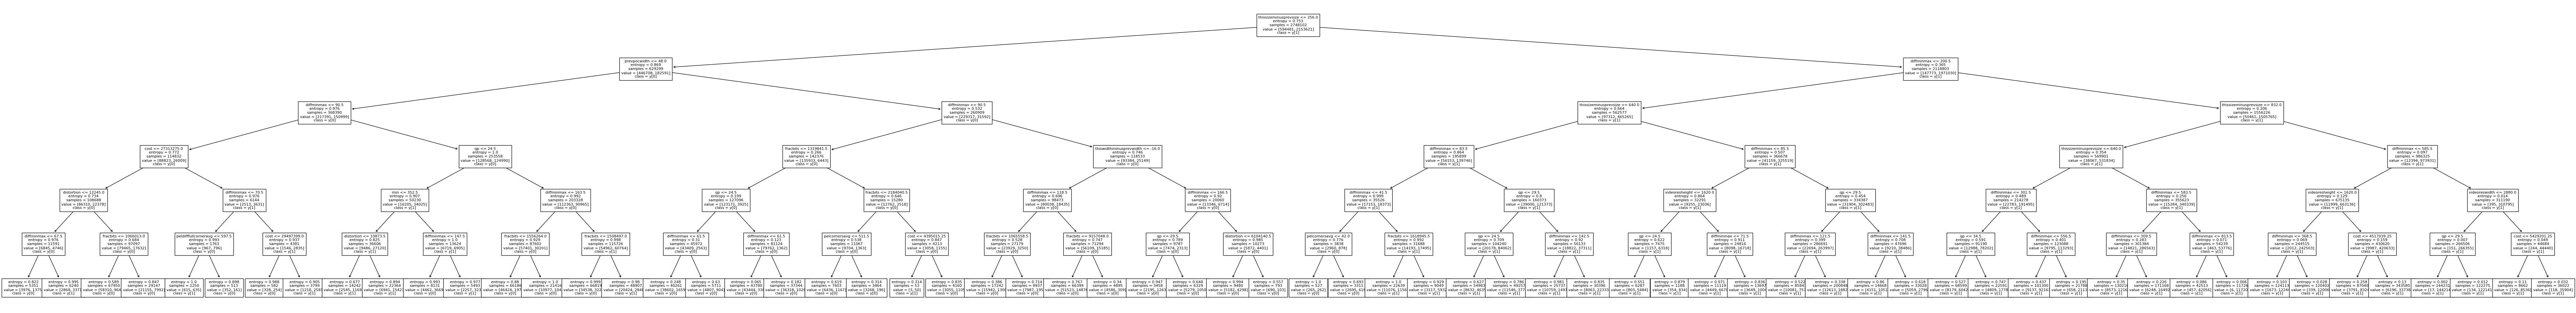

In [20]:
# Plot our decision tree.

import matplotlib.pyplot as plt


plt.figure(figsize=(100,12))  # set plot size (denoted in inches)
tree.plot_tree(model, fontsize=8, class_names=True, feature_names=['cost',"cunumberpel","currbtdepth","currdepth","currmtdepth","currqtdepth","currtrdepth","diagavg",
      "diagsad","diavar","diffminmax","distortion","fracbits","height","max","min","modetype","qp",
      "pelavg","pelcornersavg","peldiffdiagonal","peldifffullcorneravg","squaredcu","videoresheight","videoreswidth",
      "treetype","width","prevpocheight","prevpocwidth","thisheightminusprevheight","thiswidthminusprevwidth",
      "thissizeminusprevsize",'target'])
plt.show()



#tree.plot_tree(model)